In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/xhding/workspaces/torch-deep-retina')
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
import torch
import h5py
from  torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from scipy.stats import pearsonr
from scipy.special import factorial
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from fnn.evaluation import *
import fnn.models as models
from fnn.config import get_custom_cfg
from fnn.data import TestDataset, ValidationDataset
from fnn.distributions import *
from fnn.notebook.utils import *
from torchdeepretina.datas import loadexpt
from torchdeepretina.pyret_func import estfr

In [3]:
file_path = '/home/xhding/tem_stim/21-03-15/naturalscene.h5'
cells = [0,1,2,3,4,6]
t_list = [3,3,3,3,2,3]
recording = recording_stats(file_path, cells)
recording_cut = recording_stats(file_path, cells, truncate=True, t_list=t_list)
single_trial_bin = recording.single_trial_bin
single_trial_bin_cut = recording_cut.single_trial_bin

In [16]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('fc_phase2_21-03-15')
model_func = getattr(models, cfg.Model.name)
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack_FC_2/epoch_095_loss_-0.78_pearson_0.6443.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=500)
test_pc, pred, targ = pearsonr_batch_eval(model, test_data, 6, device, cfg)

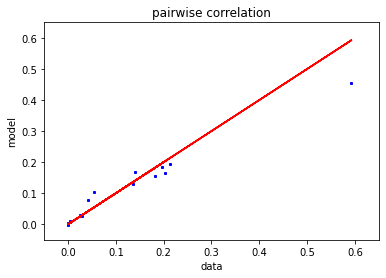

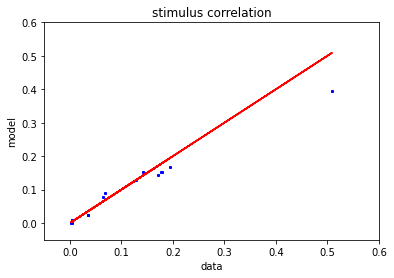

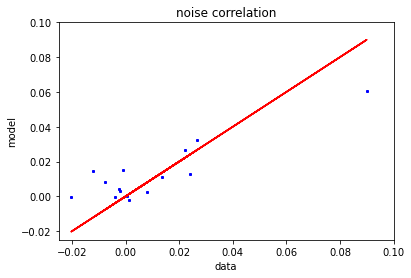

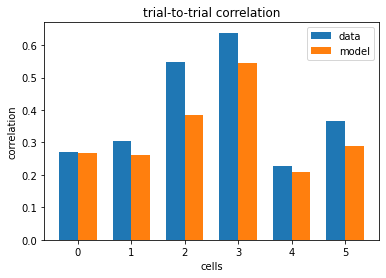

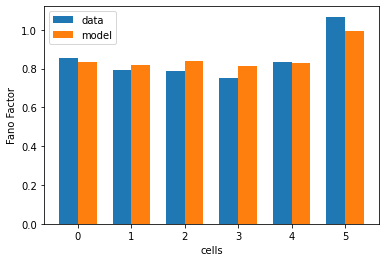

0.005567171374316402


In [58]:
binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
t_list = [3,3,3,3,2,3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0., 0., 0.1, 0.], seed=None, noise_locs=[3,4,5])
poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1, threshold=0.4, intv=0.15, sigma=True)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, seed=None, thre=1)

min_error = 10
for i in range(100):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

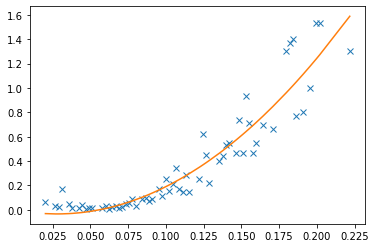

In [53]:
def poly(x,c,d):
        return c*x**2+d*x
    
cell = 2
means = []
rates = []
sigmas = []

pred_single_trial_pre[:, pred<1] = 0
for rate in np.linspace(0.25, pred_single_trial_pre.mean(0)[:, cell].max(), 100):
    mean, var, _, w = recording.stats_rate(pred_single_trial_pre.mean(0), cell=cell, rate=rate, intv=0.15)
    if var > 0:
        sigmas.append(np.sqrt(var/(w-1)))
        means.append(mean)
        rates.append(rate/100)
sigmas = np.array(sigmas)[~np.isnan(means)]
rates = np.array(rates)[~np.isnan(means)]
means = np.array(means)[~np.isnan(means)]

max_idx = np.where(means >= 0.8*means.max())[0][-1]
min_idx = np.where(rates == rates.min())[0][0]
slope = (means[max_idx] -  means[min_idx]) / (rates[max_idx] -  rates[min_idx])
means_res = means - (rates - rates[min_idx]) * slope - means[min_idx]
valid_idx = np.where(np.abs(means_res/means[max_idx]) < 0.4)

rates = rates[valid_idx]
means = means[valid_idx]
sigmas = sigmas[valid_idx]

para = curve_fit(poly, rates, means, sigma=sigmas)[0]

plt.plot(rates, means, 'x')
plt.plot(rates, [poly(rates[i], *para) for i in range(len(rates))])

In [54]:
g2_errors = []
g1_errors = []
g0_errors = []

t_list = [3,3,3,3,2,3]

for g2 in np.linspace(0., 0.2, 51):
    binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0, 0, g2, 0], noise_locs=[3,4,5])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1, threshold=0.4, intv=0.15, sigma=True)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, thre=1)
    
    min_error = 10
    
    for i in range(100):
        pred_single_trial = pred_single_trial_multi[i]
        _, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial)
        if noise_error < min_error:
            min_error = noise_error
            min_error_stim = stim_error
         
    g2_errors.append((g2, min_error_stim, min_error))

for g1 in np.linspace(0., 0.2, 51):
    binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [0, g1, 0, 0], noise_locs=[3,4,5])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1, threshold=0.4, intv=0.15, sigma=True)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, thre=1)
    
    min_error = 10
    
    for i in range(100):
        pred_single_trial = pred_single_trial_multi[i]
        _, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial)
        if noise_error < min_error:
            min_error = noise_error
            min_error_stim = stim_error
         
    g1_errors.append((g1, min_error_stim, min_error))

for g0 in np.linspace(0, 2, 51):
    binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
    pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [g0, 0, 0, 0], noise_locs=[3,4,5])
    poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1, threshold=0.4, intv=0.15, sigma=True)
    pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, thre=1)
    
    min_error = 10
    
    for i in range(100):
        pred_single_trial = pred_single_trial_multi[i]
        _, stim_error, noise_error = error_corr3(single_trial_bin, pred_single_trial)
        if noise_error < min_error:
            min_error = noise_error
            min_error_stim = stim_error
         
    g0_errors.append((g0, min_error_stim, min_error))

Stimulus correlation


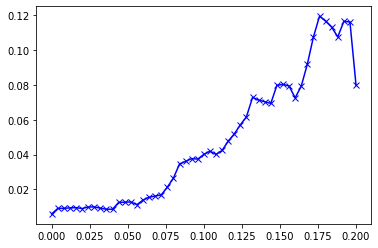

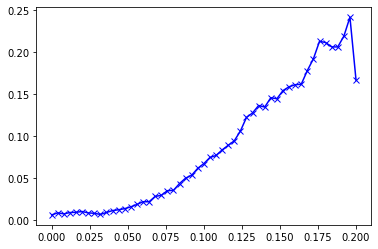

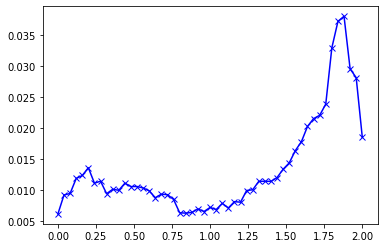

Noise correlation


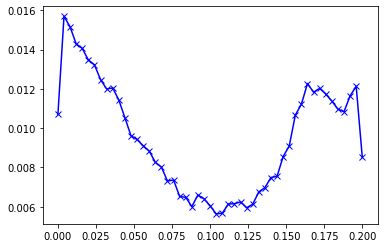

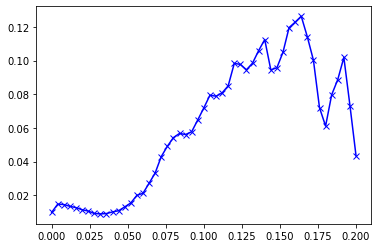

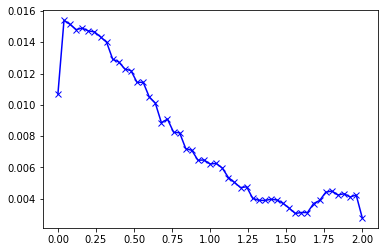

In [55]:
print("Stimulus correlation")
errors = np.convolve(np.array(g2_errors)[:, 1], np.ones(3)/3, mode='same')
plt.plot(np.array(g2_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g1_errors)[:, 1], np.ones(3)/3, mode='same')
plt.plot(np.array(g1_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g0_errors)[:, 1], np.ones(3)/3, mode='same')
plt.plot(np.array(g0_errors)[:, 0], errors, 'bx-')
plt.show()
print("Noise correlation")
errors = np.convolve(np.array(g2_errors)[:, 2], np.ones(3)/3, mode='same')
plt.plot(np.array(g2_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g1_errors)[:, 2], np.ones(3)/3, mode='same')
plt.plot(np.array(g1_errors)[:, 0], errors, 'bx-')
plt.show()
errors = np.convolve(np.array(g0_errors)[:, 2], np.ones(3)/3, mode='same')
plt.plot(np.array(g0_errors)[:, 0], errors, 'bx-')
plt.show()

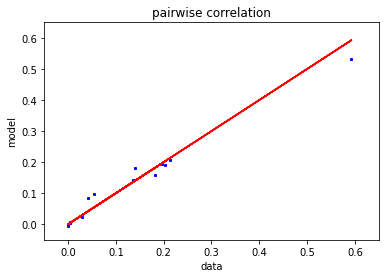

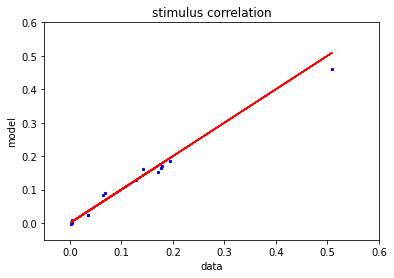

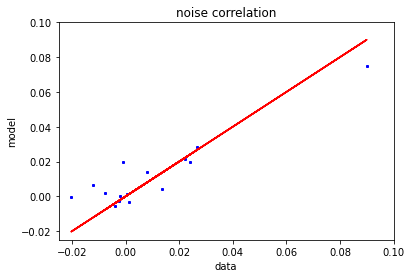

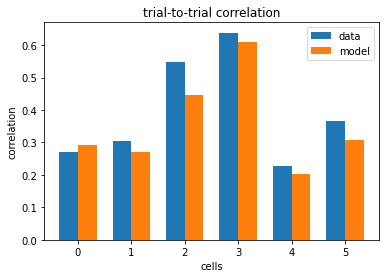

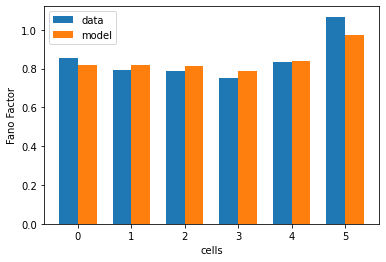

0.0033103704075412997


In [56]:
binomial_para = [2.17, 2.85, 1.91, 1.69, 1., 0.47]
t_list = [3,3,3,3,2,3]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, 15, [1.6, 0., 0., 0.], seed=None, noise_locs=[3,4,5])
poly_paras = poly_para_fit(recording, pred_single_trial_pre, pred, thre=1, threshold=0.4, intv=0.15, sigma=True)
pred_single_trial_multi = model_single_trial_post_multi(pred_single_trial_pre, binomial_para, t_list, poly_paras, pred, n_repeats=100, seed=None, thre=1)

min_error = 10
for i in range(100):
    pred_single_trial = pred_single_trial_multi[i]
    error = error_corr2(single_trial_bin, pred_single_trial)
    if error < min_error:
        min_error = error
        pred_single_trial_try = pred_single_trial
        
correlation_plot_2(single_trial_bin, pred_single_trial_try)
print(min_error)

In [59]:
single_trial_bin.sum(), pred_single_trial_try.sum()

(12160.0, 12214)

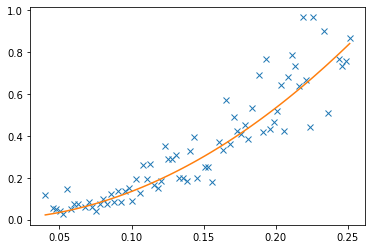

In [67]:
def poly(x,c,d):
        return c*x**2+d*x
    
cell = 5
means = []
rates = []
sigmas = []
thre = 1
pred_single_trial[:, pred<thre] = 0
for rate in np.linspace(0.25, pred_single_trial_pre.mean(0)[:, cell].max(), 100):
    mean, var, _, w = recording.stats_rate(pred_single_trial_pre.mean(0), cell=cell, rate=rate, intv=0.15)
    if var > 0:
        sigmas.append(np.sqrt(var/(w-1)))
        means.append(mean)
        rates.append(rate/100)
sigmas = np.array(sigmas)[~np.isnan(means)]
rates = np.array(rates)[~np.isnan(means)]
means = np.array(means)[~np.isnan(means)]

max_idx = np.where(means >= 0.8*means.max())[0][-1]
min_idx = np.where(rates == rates.min())[0][0]
slope = (means[max_idx] -  means[min_idx]) / (rates[max_idx] -  rates[min_idx])
means_res = means - (rates - rates[min_idx]) * slope - means[min_idx]
valid_idx = np.where(np.abs(means_res/means[max_idx]) < 0.4)

rates = rates[valid_idx]
means = means[valid_idx]
sigmas = sigmas[valid_idx]

para = curve_fit(poly, rates, means, sigma=sigmas)[0]

plt.plot(rates, means, 'x')
plt.plot(rates, [poly(rates[i], *para) for i in range(len(rates))])